## Load libraries

In [1]:
library(ggplot2)
library(dplyr)
library(reshape)
library(reshape2)
library(fgsea)
library(RColorBrewer)
library(data.table)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following object is masked from ‘package:reshape’:

    melt


The following objects are masked from ‘package:dplyr’:

    between, first, last




## Set paths to reference files

In [2]:
#Annotation of 87 selected regulons (from Fig. 3A)
annot_r2=read.table('../data/snRNA/Table_S4f_selected_regulons.txt',sep='\t',header=T)

#Targets of 258 regulons
regs=read.table('../data/snRNA/Table_S4a_regulon_targets.txt',sep='\t',header=T)
colnames(regs)=c('Gene','Regulon')

#Regulons order
regs_order=annot_r2$Regulon

#Color scale for dotplot
cols=colorRampPalette(append(brewer.pal(9,"YlOrRd"), "#FFFFFF", after=0), bias=2)(1000) 

#Gene lists of hallmark pathways
pathways.hallmark <- gmtPathways("../data/Gene_lists/h.all.v7.4.symbols.gmt.txt")

#Hallmark pathways annotation
pathw_annot=read.table('../data/Gene_lists/Hallmark_pathways_annotation.csv',sep=',',header=T)

#Tissue- and cancer-specific DEGs
degs=read.table('../data/snRNA/Table_S2b_tiss_cancer_DEGs.txt',sep='\t',header=T)
degs=degs[degs$p_val_adj<0.05 & degs$avg_log2FC>0,]

#Read RNA average expression matrix
all_genes=fread('../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv',sep='\t')

Warning message in fread("../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv", :
“Detected 233 column names but the data has 234 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [3]:
#Select regulons
regs_s=regs[regs$Regulon %in% annot_r2$Regulon,]

In [4]:
all_st=NULL
for (i in 1:length(unique(regs_s$Regulon))){
    reg_name=unique(regs_s$Regulon)[i]
    can=annot_r2$Cancer[annot_r2$Regulon==reg_name]
    
    genes_r=regs_s$Gene[regs_s$Regulon==reg_name]
    genes_r=intersect(genes_r,degs$Gene[degs$Cancer==can])
    st=NULL
    for (j in 1:length(pathways.hallmark)){
        pathw_name=names(pathways.hallmark)[j]
        genes_pathw=pathways.hallmark[[j]]
        x=length(intersect(genes_r,genes_pathw))/(length(unique(c(genes_r,genes_pathw)))) #like in heterogeneity analysis (jaccard index).
        st=cbind(st,x)
    }
    all_st=rbind(all_st,st)	
}
all_st=as.data.frame(all_st)
colnames(all_st)=names(pathways.hallmark)
rownames(all_st)=unique(regs_s$Regulon)
colnames(all_st)=gsub('HALLMARK_','',colnames(all_st))

In [5]:
pathw_annot$Geneset=gsub('\\-','_',pathw_annot$Geneset)

all_st_s=all_st[,colnames(all_st) %in% 
                c(pathw_annot$Geneset,'ESTROGEN_RESPONSE_EARLY','ESTROGEN_RESPONSE_LATE') & 
                !(colnames(all_st) %in% c('PANCREAS_BETA_CELLS','XENOBIOTIC_METABOLISM',
                                          'PEROXISOME','UV_RESPONSE_DN','UV_RESPONSE_UP'))]

In [6]:
h1=reshape2::melt(as.matrix(all_st_s))
colnames(h1)=c('Regulon','Pathway','Overlap')
h2=merge(h1,annot_r2,all.x=T)

h2=h2[h2$Overlap!=0,]

In [7]:
###Try adding FDR with FORA analysis:
sel_pathw=c(pathw_annot$Geneset[!(pathw_annot$Geneset %in% c('PANCREAS_BETA_CELLS','XENOBIOTIC_METABOLISM',
                                                             'PEROXISOME','UV_RESPONSE_DN','UV_RESPONSE_UP'))],
            c('ESTROGEN_RESPONSE_EARLY','ESTROGEN_RESPONSE_LATE'))

sel_pathw=paste('HALLMARK_',sel_pathw,sep='')
pathways.hallmark_s=pathways.hallmark[names(pathways.hallmark) %in% sel_pathw]

In [8]:
all_genes=as.data.frame(all_genes)
universe_genes=all_genes$V1

In [9]:
all_res=NULL
for (i in 1:length(unique(regs_s$Regulon))){
    reg_name=unique(regs_s$Regulon)[i]
    can=annot_r2$Cancer[annot_r2$Regulon==reg_name]

    genes_r=regs_s$Gene[regs_s$Regulon==reg_name]
    genes_r=intersect(genes_r,degs$Gene[degs$Cancer==can])

    foraRes=fora(pathways.hallmark_s, genes_r, universe_genes, minSize = 5, maxSize = Inf)
    foraRes$ID=reg_name
    foraRes$DEGs_N=length(genes_r)
    foraRes$Cancer=can
    all_res=rbind(all_res, as.data.frame(foraRes[,c(1:5,7:9)]))
}

In [10]:
all_res_s=all_res[,c(1,3,6,8)]
colnames(all_res_s)=c('Pathway','padj','Regulon','Cancer')
all_res_s$Pathway=gsub('HALLMARK_','',all_res_s$Pathway)

In [11]:
h3=merge(h2[,-5],all_res_s,all.x=T)
h4=h3[h3$Overlap>=0.01 & h3$padj<0.05,]
h4$Cancer=factor(h4$Cancer,
                      levels=(c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM')))

## Do plotting with ggplot2

In [12]:
p <- ggplot()

p <- p + facet_grid(.~Cancer,drop=T,scales = "free", space = "free")

p <- p + geom_point(data=h4,aes(x=Regulon, y=Pathway, fill= Overlap,size=-log10(padj)), shape=21,color="black") 

p <- p + scale_fill_gradientn(name= "Jaccard", colours=cols, na.value="grey") 

p <- p  + theme_minimal()+theme_bw()

p <- p + theme(panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "grey80"))


p <- p + theme(panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))

p <- p + theme(axis.title = element_blank(), 
               axis.text.x = element_text(colour="black", size=12, angle=90, vjust = 0.5), 
               axis.text.y = element_text(colour="black", size=11),axis.ticks = element_blank())

p <- p + theme(axis.text.x = element_text(angle = 90,hjust = 0.95,vjust = 0.2))	

p <- p + theme(strip.text.x.top = element_text(angle = 90),legend.position='bottom')


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


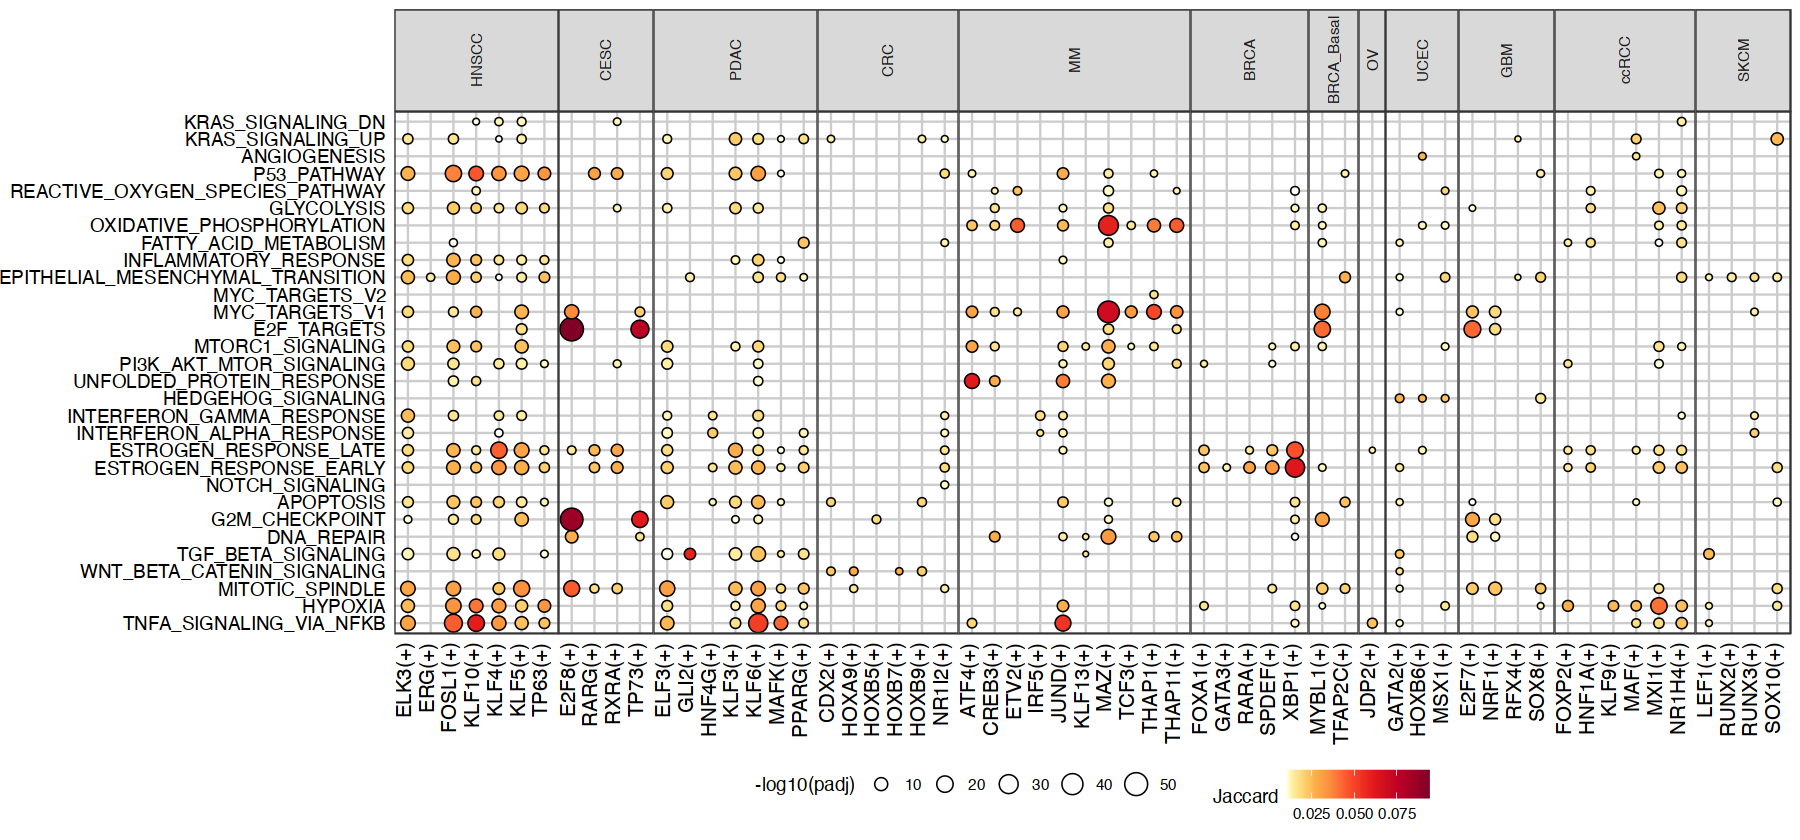

In [ ]:
options(repr.plot.width=15, repr.plot.height=7)
p